# EE6310 - Image and Video Processing
Homework-6

## Imports

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
from PIL import Image
import cv2
import random
import os
import tarfile
import pickle
!pip3 install tqdm
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Defaulting to user installation because normal site-packages is not writeable


## Q1 - Motion Estimation

Implementation of the Motion Estimator

### Functions

- Mean Absolute Distance (MAD)
- Search Neighbourhood
- Estimate Flow
- Plotting Arrow Vectors
- Predict Frame suing Arrow Vectors

#### Mean Absolute Distance
Function calculates MAD of 2 MacroBlocks

In [2]:
def MAD(Block1, Block2):
    return np.mean(np.abs(Block1 - Block2))

#### Search Neighbourhood

Finds $(d_1,d_2)$ of each MacroBlock of Frame-2 in Frame-1

In [3]:
def SearchNeighbourhood(MacroBlock,I,p,q,Positions):
    
    Distances = {}
    for s in Positions:
        if (p+s[0])>=0 and (p+15+s[0])<I.shape[0] and (q+s[1])>=0 and (q+15+s[1])<I.shape[1]:
            Distances[s] = MAD(I[p+s[0]:p+16+s[0], q+s[1]:q+16+s[1]],MacroBlock)
            
    SD = sorted(Distances.items(), key = lambda t:(t[1], t[0]))
    
    return SD[0][0]

#### Estimate Flow

- MacroBlocks of **I** are searched in **J**.
- **D** (Movements) consists of $(d_1, d_2)$ of each MacroBlocks in **I**.

In [4]:
def EstimateFlow(I,J,M,D):
    l,m = I.shape
    a,b = int(l/16),int(m/16)
    MBDist = np.zeros((a,b,2)).astype(int)
    
    Move = [-M,0,M]
    Positions = []
    for i in Move:
        for j in Move:
            Positions.append((i,j))
    
    for i in range(a):
        for j in range(b):
            p = 16*i + D[i][j][0]
            q = 16*j + D[i][j][1]
            MacroBlock = I[16*i:16*(i+1), 16*j:16*(j+1)]
            
            MBDist[i,j,:] = SearchNeighbourhood(MacroBlock,J,p,q,Positions)
            
    return MBDist

#### Plotting Arrow Vectors
Plotting Motion Vectors from Frame-2 to Frame-1 for each MacroBlock

In [5]:
def PlotArrowVector(D,H,W,MacroBlockDims=(16,16)):
	x = MacroBlockDims[0]*np.arange(0,int(W/MacroBlockDims[0]))
	y = MacroBlockDims[1]*np.arange(0,int(H/MacroBlockDims[1]))

	x,y = np.meshgrid(x,y)
	x = x.flatten()
	y = y.flatten()
	dx = D[:,:,1].flatten()
	dy = D[:,:,0].flatten()

	plt.figure(figsize=(12,12))
	plt.grid()
	plt.title('Motion Vector of Each MacroBlock from Frame-2 to Frame-1\n', fontsize=15, fontweight=900)
	plt.quiver(x, y, dx, dy, angles='xy', scale_units='xy',scale=1,width=0.01,headwidth=25,headlength=15,color='red')
	plt.scatter(x,y,color='blue')
	plt.xlim(-MacroBlockDims[1], W)
	plt.ylim(H, -MacroBlockDims[0])
	plt.show()

#### Predict Frame using Arrow Vectors
Predicting Second Frame using First Frame and Motion Vectors from Second Frame to First Frame.

In [6]:
def PredictFrame(I,D):
    PredFrame = np.zeros(I.shape)
    l,m = D.shape[0:2]
    
    for i in range(l):
        for j in range(m):
            PredFrame[16*i:16*(i+1),16*j:16*(j+1)] = I[D[i][j][0] + 16*i:D[i][j][0] + 16*(i+1), D[i][j][1] + 16*j:D[i][j][1] + 16*(j+1)]
    return PredFrame

### Loading frames and Visualisation

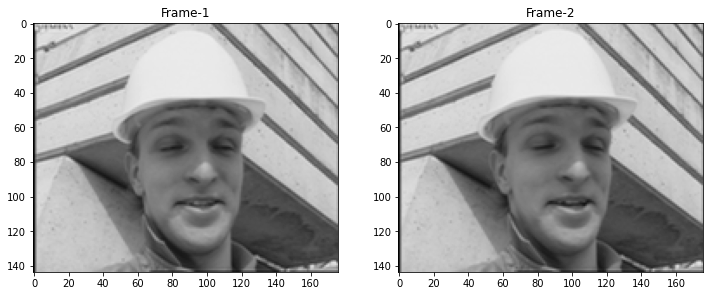

In [7]:
# Loading Frames
Frame1 = pimg.imread('Images/first_frame.png')
Frame2 = pimg.imread('Images/second_frame.png')

# Displaying Frames
plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
plt.imshow(Frame1,cmap='gray')
plt.title("Frame-1")

plt.subplot(1,2,2)
plt.imshow(Frame2,cmap='gray')
plt.title("Frame-2")

plt.show()

### 1.1 - Finding Motion Vectors

In [8]:
# Step-1
D0 = np.zeros((int(Frame1.shape[0]/16), int(Frame1.shape[1]/16), 2)).astype(int)
D1 = EstimateFlow(Frame2, Frame1, 4, D0) + D0

# Step-2
D2 = EstimateFlow(Frame2, Frame1, 2, D1) + D1

# Step-3
D = EstimateFlow(Frame2, Frame1, 2, D2) + D2

### 1.2 - Plotting Motion Vectors of each MacroBlock

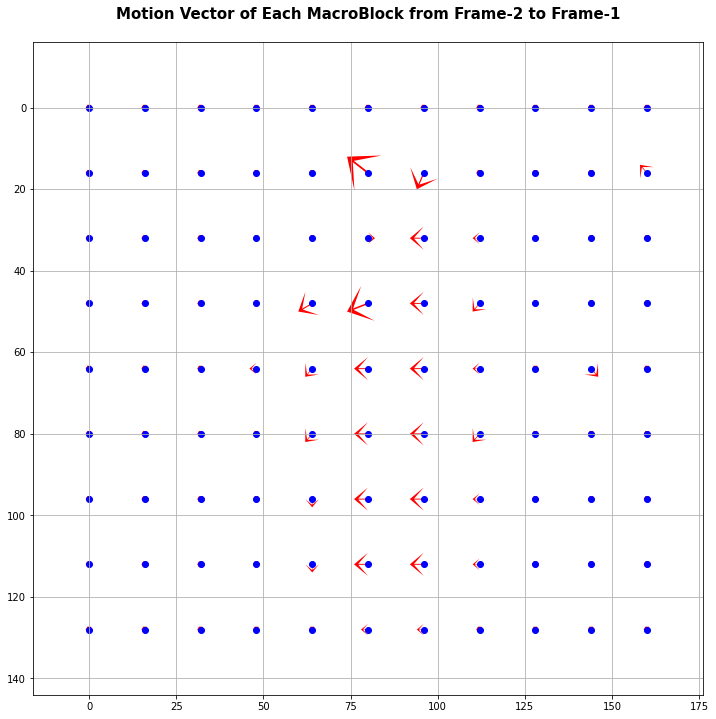

In [9]:
PlotArrowVector(D, Frame1.shape[0], Frame1.shape[1])

### 1.3 - Generating motion compensated predicted frame using motion vectors and first frame

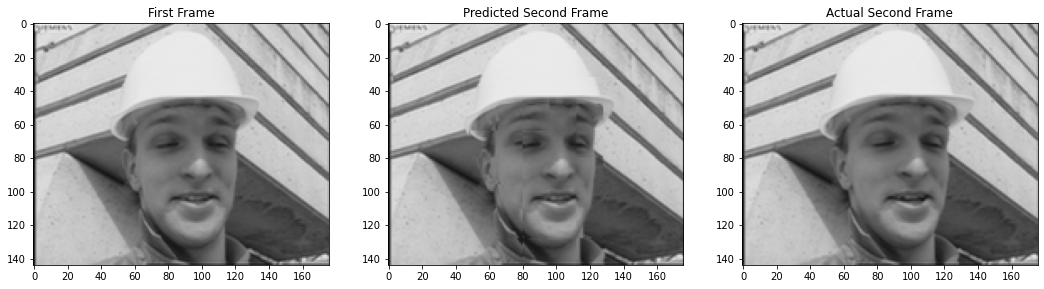

In [10]:
# Predicitng Frame2
pred_Frame2 = PredictFrame(Frame1, D)

# Displaying Frames
plt.figure(figsize=(18,12))

plt.subplot(1,3,1)
plt.title('First Frame')
plt.imshow(Frame1,cmap='gray')

plt.subplot(1,3,2)
plt.title('Predicted Second Frame')
plt.imshow(pred_Frame2,cmap='gray')

plt.subplot(1,3,3)
plt.title('Actual Second Frame')
plt.imshow(Frame2,cmap='gray')

plt.show()

### 1.4 Error between second frame and motion compensated predicted frame

Error =  3.4397096488145036


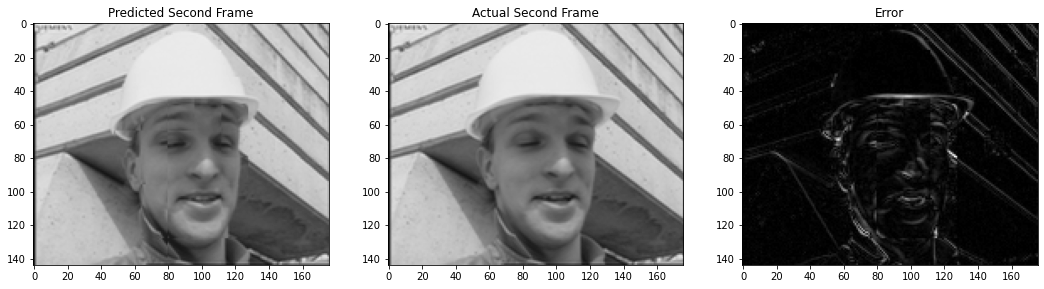

In [11]:
# Printing Error
print ("Error = ", 255*MAD(Frame2, pred_Frame2))

# Displaying Error
plt.figure(figsize=(18,12))

plt.subplot(1,3,1)
plt.title('Predicted Second Frame')
plt.imshow(pred_Frame2,cmap='gray')

plt.subplot(1,3,2)
plt.title('Actual Second Frame')
plt.imshow(Frame2,cmap='gray')

plt.subplot(1,3,3)
plt.title('Error')
plt.imshow(np.abs(Frame2 - pred_Frame2),cmap='gray')

plt.show()

## Q2 - SSIM index
Structural Similarity Index Measure (SSIM): Image Quality Assessment Technique. It's basic idea is to combine local measures of similarity of luminance, contrast, structure into local measure of quality.

$\operatorname{SSIM}_{I, J}(i, j) = L_{I, J}(i, j) C_{I, J}(i, j) S_{I, J}(i, j)$
- $L_{I, J}(i, j)$ is a measure of local luminance similarity
- $C_{I, J}(i, j)$ is a measure of local contrast similarity
- $S_{I, J}(i, j)$ is a measure of local structure similarity


### Functions
- Adding Noise
- Blurring
- Compressing
- Weighting Function
- Mu Function
- Sigma Function
- CoVariance Function

**Adding Noise:** Adding gaussian noise to image.

In [12]:
def AddNoise(I, mu=0, sigma=0.1):
	# Pixel values of I are between [0,255] and is a grayscale image
	Noise = np.round(255*np.random.normal(mu,sigma,I.shape)).astype(int)
	
	return np.clip(I + Noise, 0, 255)

**Blurring:** Using Moving Average to blur the image.

In [13]:
def Blurring(I, kernel_size=(3,3)):
	# Pixel values of I are between [0,255] and is a grayscale image
	B = np.ones(kernel_size)/(kernel_size[0] * kernel_size[1])

	J = np.zeros((I.shape[0] + kernel_size[0] - 1, I.shape[1] + kernel_size[1] - 1))
	J[int(kernel_size[0]/2):I.shape[0] + int(kernel_size[0]/2), int(kernel_size[1]/2):I.shape[1] + int(kernel_size[1]/2)] = I

	O = np.zeros((I.shape[0], I.shape[1]))
	for i in range(0, I.shape[0]):
		for j in range(0, I.shape[1]):
			O[i, j] = np.sum(np.multiply(B, J[i:i+kernel_size[0], j:j+kernel_size[1]]))
		
	return np.round(O).astype(int)

**Compressing:** Compressing Image

In [14]:
def CompressImage(Path):
	img = Image.open(Path).convert("L")
	New_Path = Path[:-3] + "jpeg"
	img.save(New_Path, "JPEG", optimize = True, quality = 10)

	return cv2.resize(np.array(Image.open(New_Path)), (128,128))

**Weighting Function**

In [15]:
def WeightingFunction(size=(3,3)):
	# Size should be (odd, odd)
	P = int(0.5 * size[0])
	Q = int(0.5 * size[1])
	M = np.ones(size)/(size[0] * size[1])
	W = {}

	for p in range(-P, P+1):
		for q in range(-Q, Q+1):
			W[(p,q)] = M[p+P, q+Q]

	return W

**Mu Function**

In [16]:
def MuFunction(I,W):
	# Pixel values of I are between [0,255] and is a grayscale image
	Mu = np.zeros(I.shape)

	for i in range(I.shape[0]):
		for j in range(I.shape[1]):
			for p,q in W.keys():
				try:
					Mu[i,j] += (W[(p,q)] * I[i+p, j+q])
				except:
					Mu[i,j] += 0	
	return I

**Sigma Function**

In [17]:
def SigmaFunction(I,W):
	# Pixel values of I are between [0,255] and is a grayscale image
	Mu = MuFunction(I,W)
	Sigma = np.zeros(I.shape)

	for i in range(I.shape[0]):
		for j in range(I.shape[1]):
			for p,q in W.keys():
				try:
					Sigma[i,j] += (W[(p,q)] * (I[i+p, j+q] - Mu[i,j])**2)
				except:
					Sigma[i,j] += 0
	
	return np.sqrt(Sigma)

**CoVariance Function**

In [18]:
def CoVarianceFunction(I, J, MuI, W):
	# Pixel values of I,J are between [0,255] and is a grayscale image
	MuJ = MuFunction(I,W)
	CoVariance = np.zeros(I.shape)

	for i in range(I.shape[0]):
		for j in range(I.shape[1]):
			for p,q in W.keys():
				try:
					CoVariance[i,j] += (W[(p,q)] * (I[i+p, j+q] - MuI[i,j]) * (J[i+p, j+q] - MuJ[i,j]))
				except:
					CoVariance[i,j] += 0
	
	return CoVariance

### Luminance Similarity

In [19]:
def LuminanceSimilarity(J, MuI, W, C1 = (0.01 * 255)**2):
	# Pixel values of I,J are between [0,255] and is a grayscale image
	
	L = np.zeros(MuI.shape)
	MuJ = MuFunction(J, W)

	for i in range(L.shape[0]):
		for j in range(L.shape[1]):
			L[i,j] = (2*MuI[i,j]*MuJ[i,j] + C1)/(MuI[i,j]*MuI[i,j] + MuJ[i,j]*MuJ[i,j] + C1)

	return L

### Contrast Similarity

In [20]:
def ContrastSimilarity(J, SigmaI, W, C2 = (0.03 * 255)**2):
	# Pixel values of I,J are between [0,255] and is a grayscale image

	C = np.zeros(SigmaI.shape)
	SigmaJ = SigmaFunction(J, W)

	for i in range(C.shape[0]):
		for j in range(C.shape[1]):
			C[i,j] = (2*SigmaI[i,j]*SigmaJ[i,j] + C2)/(SigmaI[i,j]*SigmaI[i,j] + SigmaJ[i,j]*SigmaJ[i,j] + C2)

	return C

### Structural Similarity

In [21]:
def StructuralSimilarity(I, J, MuI, SigmaI, W, C3 = 0.5 * (0.03 * 255)**2):
	# Pixel values of I,J are between [0,255] and is a grayscale image

	S = np.zeros(I.shape)
	SigmaJ = SigmaFunction(J, W)
	CoVariance = CoVarianceFunction(I,J,MuI,W)

	for i in range(I.shape[0]):
		for j in range(I.shape[1]):
			S[i,j] = (2*CoVariance[i,j] + C3)/(SigmaI[i,j]*SigmaJ[i,j] + C3)

	return S

### SSIM index

In [22]:
def SSIMindex(I, MuI, SigmaI, J):
	# Pixel values of I,J are between [0,255] and is a grayscale image
	
	L = LuminanceSimilarity(J,MuI,W)
	C = ContrastSimilarity(J,SigmaI,W)
	S = StructuralSimilarity(I,J,MuI,SigmaI,W)

	Map = np.multiply(np.multiply(L,C), S)
	Value = np.mean(Map)

	return Map, Value

### Testing on Images

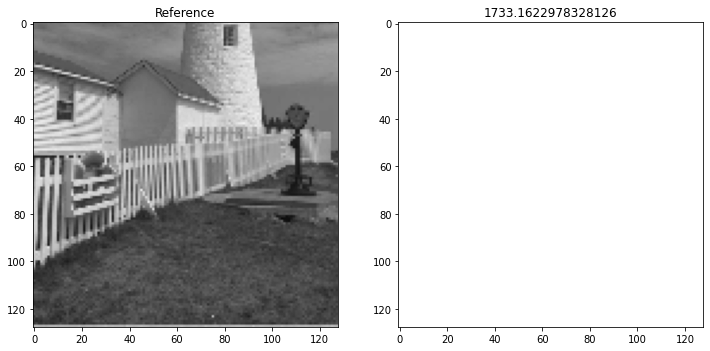

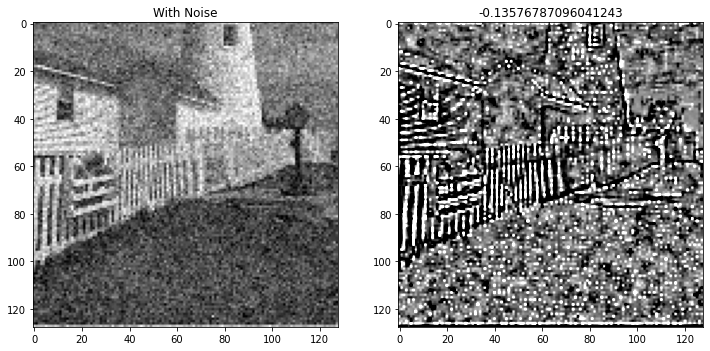

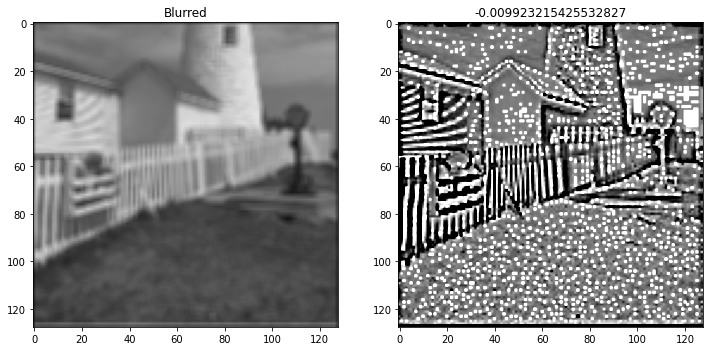

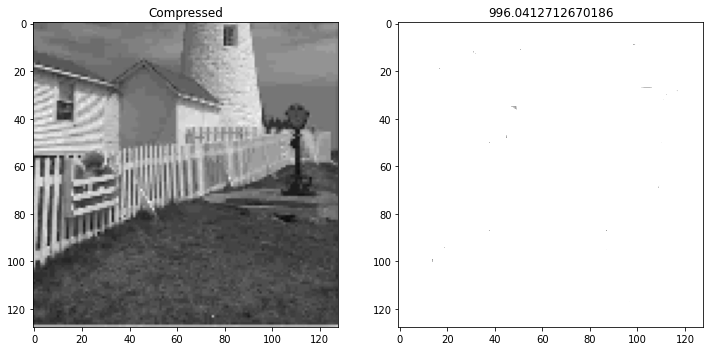

In [23]:
# Reading Image
I = cv2.resize(np.array(Image.open("Images/lighthouse.png").convert('L')), (128,128))

# Reference Image Properties for SSIM index calculations
W = WeightingFunction()
MuI = MuFunction(I, W)
SigmaI = SigmaFunction(I, W)

# Images
Images = [("Reference", I), ("With Noise", AddNoise(I)), ("Blurred", Blurring(I)), ("Compressed", CompressImage("Images/lighthouse.png"))]

# Displaying Images
for Description, J in Images:
	SSIM_Map, Value = SSIMindex(I, MuI, SigmaI, J)

	plt.figure(figsize=(12,6))

	plt.subplot(1,2,1)
	plt.title(Description)
	plt.imshow(J, vmin=0, vmax=255, cmap='gray')
	
	plt.subplot(1,2,2)
	plt.title(str(Value))
	plt.imshow(SSIM_Map, vmin=-1, vmax=1, cmap='gray')
	plt.show()